In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import yfinance as yf
import riskfolio.RiskFunctions as rk
import warnings

warnings.filterwarnings("ignore")

# Date range
start = '2010-01-01'

# List of assets
assets = ['^GSPC', 'JPM', 'MSFT', 'GOLD']

# Downloading the data
data = yf.download(assets, start = start)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets
ret = data.pct_change().dropna()

display(ret.head())

[*********************100%***********************]  4 of 4 completed


,^GSPC,JPM,MSFT,GOLD
Date,,,,
2010-01-04,0.025648,0.029553,0.015420,0.016043
2010-01-05,0.012380,0.019370,0.000323,0.003116
2010-01-06,0.021276,0.005494,-0.006137,0.000546
2010-01-07,-0.014129,0.019809,-0.010400,0.004001
2010-01-08,0.006316,-0.002456,0.006897,0.002882


In [2]:
n = ret.shape[0]

Risk_norm = {}
for i in assets:
    Risk_norm[i] = {'VaR':[], 'CVaR': [], 'EVaR': []}

window = 250 * 1
alpha = 0.05

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        z = st.norm.ppf(1 - alpha)
        mu, sigma = st.norm.fit(X)
        Risk_norm[j]['VaR'].append(mu - z * sigma)
        Risk_norm[j]['CVaR'].append(mu - sigma * st.norm.pdf(z) / alpha)
        Risk_norm[j]['EVaR'].append(mu - sigma * np.sqrt(-2 * np.log(alpha)))

for i in assets:
    Risk_norm[i] = pd.DataFrame(Risk_norm[i], index=ret.index[window:])

[]

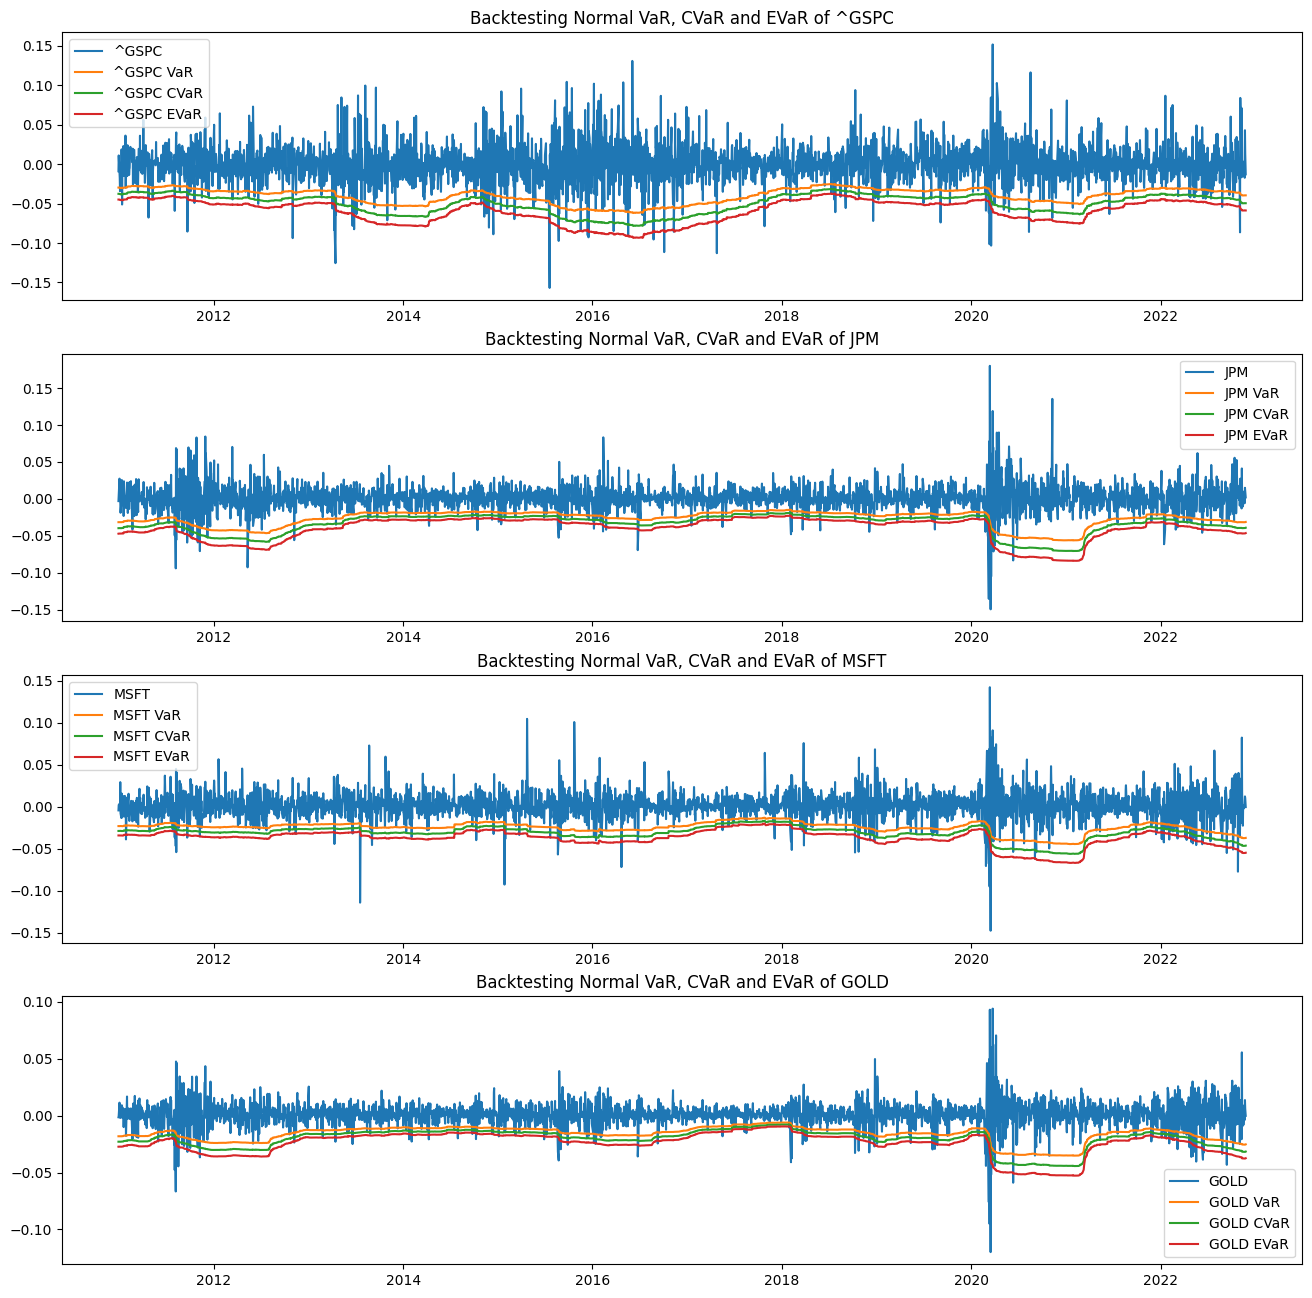

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_norm[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_norm[assets[i]]['CVaR'], label=assets[i] + ' CVaR')
    ax[i].plot(Risk_norm[assets[i]]['EVaR'], label=assets[i] + ' EVaR')
    ax[i].legend()
    ax[i].set_title('Backtesting Normal VaR, CVaR and EVaR of ' + assets[i])

plt.plot()

In [4]:
def bern_test(p,v):
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    return (-2*(al-bl))

def ind_test(V):
    T = len(V)
    J = np.full([T,4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    return (-2*(al-bl))

In [5]:
keys = ['Failure Ratio VaR', 
        'Failure Ratio CVaR',
        'Failure Ratio EVaR',
        'Bernoulli Test VaR stat',
        'Bernoulli Test VaR p-value',
        'Bernoulli Test CVaR stat',
        'Bernoulli Test CVaR p-value',
        'Bernoulli Test EVaR stat',
        'Bernoulli Test EVaR p-value',
        'Independent Test VaR stat',
        'Independent Test VaR p-value',
        'Independent Test CVaR stat',
        'Independent Test CVaR p-value',
        'Independent Test EVaR stat',
        'Independent Test EVaR p-value']

Stats_norm = {}
    
for i in assets:
    Stats_norm[i] = {}
    for j in keys:
        Stats_norm[i][j] = []

for i in Stats_norm.keys():
    for j in Risk_norm[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_norm[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_norm[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_norm[i]['Failure Ratio ' + j].append(H/T)
        Stats_norm[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_norm[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_norm[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_norm[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_norm[i] = pd.DataFrame(Stats_norm[i]).T
    Stats_norm[i].columns = [i]
    a = pd.concat([a, Stats_norm[i]], axis=1)

Stats_norm = a
display(Stats_norm)

,^GSPC,JPM,MSFT,GOLD
Failure Ratio VaR,0.051034,0.050033,0.052702,0.060040
Failure Ratio CVaR,0.028019,0.031688,0.028686,0.038025
Failure Ratio EVaR,0.016011,0.017345,0.019680,0.028352
Bernoulli Test VaR stat,0.067050,0.000070,0.453070,5.995080
Bernoulli Test VaR p-value,0.795690,0.993310,0.500880,0.014350
Bernoulli Test CVaR stat,36.015710,24.194130,33.656230,9.831080
Bernoulli Test CVaR p-value,0.000000,0.000000,0.000000,0.001720
Bernoulli Test EVaR stat,98.081410,89.019920,74.643930,34.823860
Bernoulli Test EVaR p-value,0.000000,0.000000,0.000000,0.000000
Independent Test VaR stat,13.209730,39.066710,15.755350,20.335910


In [ ]:
n = ret.shape[0]

Risk_hist = {}
for i in assets:
    Risk_hist[i] = {'VaR':[], 'CVaR': [], 'EVaR': []}

window = 250 * 1
alpha = 0.05

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        Risk_hist[j]['VaR'].append(-rk.VaR_Hist(X, alpha=alpha))
        Risk_hist[j]['CVaR'].append(-rk.CVaR_Hist(X, alpha=alpha))
        Risk_hist[j]['EVaR'].append(-rk.EVaR_Hist(-X, alpha=alpha)[0])

for i in assets:
    Risk_hist[i] = pd.DataFrame(Risk_hist[i], index=ret.index[window:])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_hist[assets[i]]['VaR'], label=assets[i] + ' VaR')
    ax[i].plot(Risk_hist[assets[i]]['CVaR'], label=assets[i] + ' CVaR')
    ax[i].plot(Risk_hist[assets[i]]['EVaR'], label=assets[i] + ' EVaR')
    ax[i].legend()
    ax[i].set_title('Backtesting Historical VaR, CVaR and EVaR of ' + assets[i])

plt.plot()

In [ ]:
Stats_hist = {}
    
for i in assets:
    Stats_hist[i] = {}
    for j in keys:
        Stats_hist[i][j] = []

for i in Stats_hist.keys():
    for j in Risk_hist[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_hist[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_hist[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_hist[i]['Failure Ratio ' + j].append(H/T)
        Stats_hist[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_hist[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_hist[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_hist[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_hist[i] = pd.DataFrame(Stats_hist[i]).T
    Stats_hist[i].columns = [i]
    a = pd.concat([a, Stats_hist[i]], axis=1)

Stats_hist = a
display(Stats_hist)

In [ ]:
from arch import arch_model

n = ret.shape[0]

Risk_EG = {}
for i in assets:
    Risk_EG[i] = {'EWMA':[], 'GARCH': []}

window = 250 * 1
alpha = 0.05
l = 0.94
s = 0

for j in assets:
    for i in range(window, n):
        X = ret[j].iloc[i-window:i]
        z = st.norm.ppf(1 - alpha)
        mu, sigma = st.norm.fit(X)
        if i == window:
            s1 = sigma**2
        else:
            s1 = l * s1 + (1-l) * X[-2]**2
        
        VaR_ewma = -st.norm.ppf(1-alpha) * np.sqrt(s1)

        am = arch_model(X, mean='Zero',vol='Garch',
                        p=1, o=0, q=1, dist='Normal',
                        rescale=False)
        res = am.fit(update_freq=0, disp='off', show_warning=False)
        par = [res.params[0], res.params[1], res.params[2]]
        s2 = par[0] + par[1] * X[-2]**2 + par[2] * res.conditional_volatility[-1]**2
        VaR_garch = -np.sqrt(s2) * st.norm.ppf(1-alpha)
        
        Risk_EG[j]['EWMA'].append(VaR_ewma)
        Risk_EG[j]['GARCH'].append(VaR_garch)

for i in assets:
    Risk_EG[i] = pd.DataFrame(Risk_EG[i], index=ret.index[window:])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(assets),1,figsize=(16, 16))

for i in range(len(assets)):
    ax[i].plot(ret[assets[i]].iloc[window:], label=assets[i])
    ax[i].plot(Risk_EG[assets[i]]['EWMA'], label=assets[i] + ' EWMA VaR')
    ax[i].plot(Risk_EG[assets[i]]['GARCH'], label=assets[i] + ' GARCH(1,1) VaR')
    ax[i].legend()
    ax[i].set_title('Backtesting EWMA and GARCH(1,1) VaR of ' + assets[i])

plt.plot()

In [ ]:
keys = ['Failure Ratio EWMA', 
        'Failure Ratio GARCH',
        'Bernoulli Test EWMA stat',
        'Bernoulli Test EWMA p-value',
        'Bernoulli Test GARCH stat',
        'Bernoulli Test GARCH p-value',
        'Independent Test EWMA stat',
        'Independent Test EWMA p-value',
        'Independent Test GARCH stat',
        'Independent Test GARCH p-value']

Stats_EG = {}
    
for i in assets:
    Stats_EG[i] = {}
    for j in keys:
        Stats_EG[i][j] = []

for i in Stats_EG.keys():
    for j in Risk_EG[i].keys():
        a = np.minimum(ret[i].iloc[window:] - Risk_EG[i][j],0)
        H = np.count_nonzero(a)
        T = Risk_EG[i].shape[0]
        q = a < 0
        v = a * 0
        v[q] = 1
        ber = bern_test(alpha, v)
        ind = ind_test(v)
        Stats_EG[i]['Failure Ratio ' + j].append(H/T)
        Stats_EG[i]['Bernoulli Test ' + j + ' stat'].append(round(ber, 5))
        Stats_EG[i]['Bernoulli Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ber, 1),5))
        Stats_EG[i]['Independent Test ' + j + ' stat'].append(round(ind, 5))
        Stats_EG[i]['Independent Test ' + j + ' p-value'].append(round(1 - st.chi2.cdf(ind, 1),5))
        
a = pd.DataFrame([])        
for i in assets:
    Stats_EG[i] = pd.DataFrame(Stats_EG[i]).T
    Stats_EG[i].columns = [i]
    a = pd.concat([a, Stats_EG[i]], axis=1)

Stats_EG = a
display(Stats_EG)